In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV #, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, SelectKBest #, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

## Data Import & Cleaning

In [2]:
# read CSV
df = pd.read_csv("cross_sell_data.csv")

# display first 10 records
df.head(n=10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [3]:
# view shape of data frame
df.shape

(381109, 12)

#### Update Data Types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [5]:
# update floats to int to remove decimal, then string
df['Region_Code'] = df['Region_Code'].astype(int)
df['Region_Code'] = df['Region_Code'].astype(str)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  object 
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  object 
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 34.9+ MB


In [6]:
# remove ID variable
df.drop('id', axis=1, inplace=True)

In [7]:
# display first 10 records
df.head(n=10)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1
1,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0
2,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1
3,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0
4,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0
5,Female,24,1,33,0,< 1 Year,Yes,2630.0,160,176,0
6,Male,23,1,11,0,< 1 Year,Yes,23367.0,152,249,0
7,Female,56,1,28,0,1-2 Year,Yes,32031.0,26,72,1
8,Female,24,1,3,1,< 1 Year,No,27619.0,152,28,0
9,Female,32,1,6,1,< 1 Year,No,28771.0,152,80,0


In [8]:
# describe data frame
df.describe()

,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,0.458210,30564.389581,154.347397,0.122563
std,15.511611,0.046110,0.498251,17213.155057,83.671304,0.327936
min,20.000000,0.000000,0.000000,2630.000000,10.000000,0.000000
25%,25.000000,1.000000,0.000000,24405.000000,82.000000,0.000000
50%,36.000000,1.000000,0.000000,31669.000000,154.000000,0.000000
75%,49.000000,1.000000,1.000000,39400.000000,227.000000,0.000000
max,85.000000,1.000000,1.000000,540165.000000,299.000000,1.000000


#### Check for Null Values

In [9]:
# check for nulls
df.isna().sum() 

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## Test & Train Split

In [10]:
# split dataset into 33% test, 67% train
train, test = train_test_split(df, test_size=0.33, random_state=42, shuffle=False)

In [11]:
# view shape of training dataset
train.shape

(255343, 11)

In [12]:
# view shape of test dataset
test.shape

(125766, 11)

## Exploratory Data Analysis

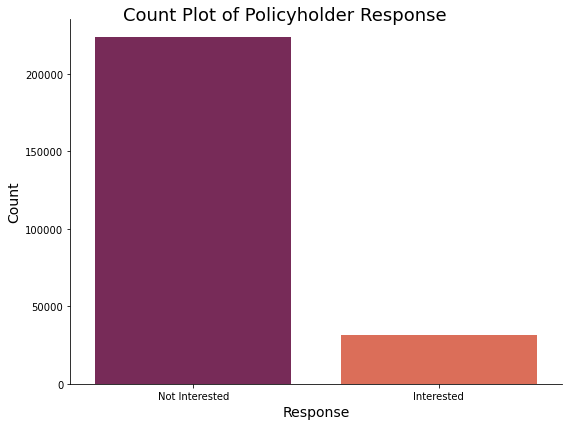

In [13]:
# set figure size
plt.figure(figsize=(8, 6))

# create count plot
sns.countplot(x=train.Response, palette="rocket")

# add title and axis labels
plt.suptitle("Count Plot of Policyholder Response", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Response", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# update x tick labels
plt.xticks([0,1],['Not Interested','Interested'])

# remove top/right border
sns.despine()

# display plot
plt.show()

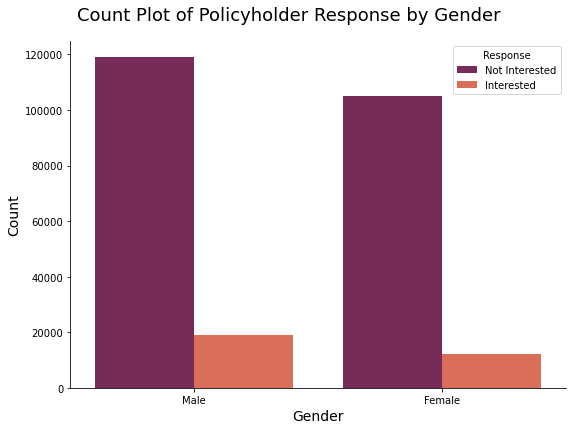

In [14]:
# set figure size
plt.figure(figsize=(8, 6))

# create countplot
sns.countplot(x=train.Gender, hue=train.Response, palette="rocket")

# update legend labels
plt.legend(labels=["Not Interested", "Interested"], title="Response")

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# add title and axis labels
plt.suptitle("Count Plot of Policyholder Response by Gender", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Gender", size=14)

# remove top/right border
sns.despine()

plt.show()

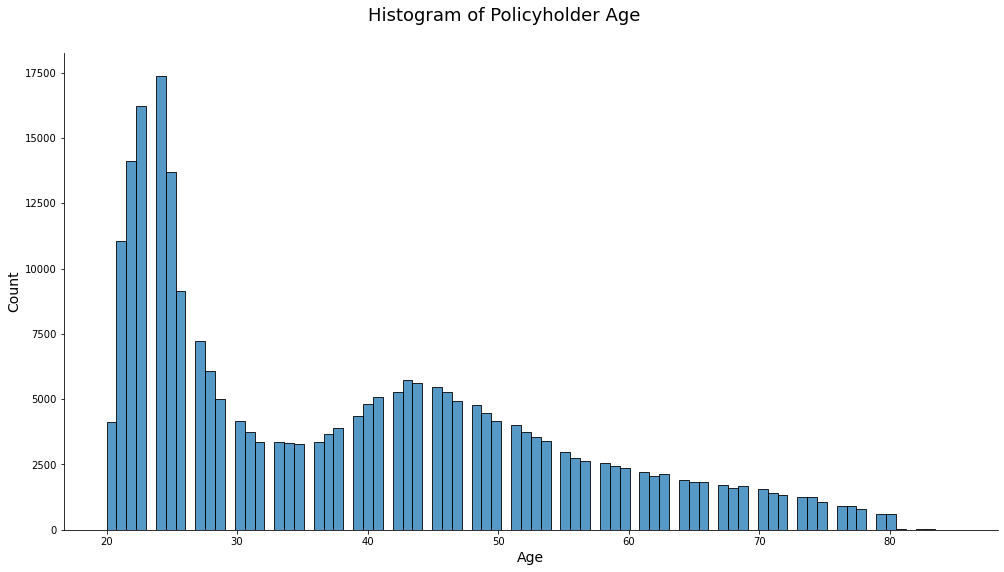

In [15]:
# set figure size
plt.figure(figsize=(14, 8))

# create countplot
sns.histplot(x=train.Age)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# add title and axis labels
plt.suptitle("Histogram of Policyholder Age", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Age", size=14)

# remove top/right border
sns.despine()

plt.show()

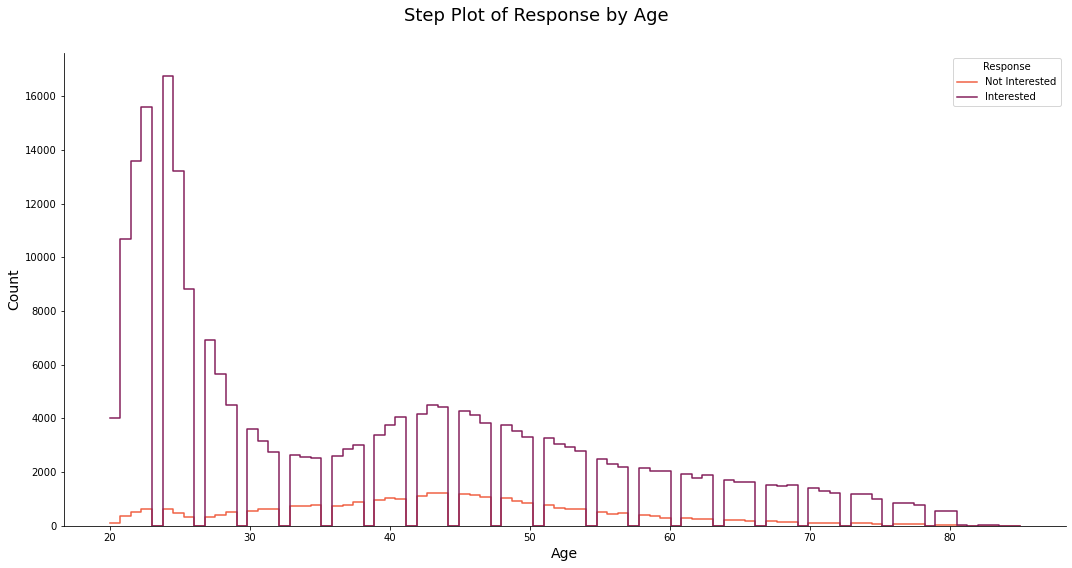

In [16]:
# set figure size
plt.figure(figsize=(15, 8))

# create hist plot
sns.histplot(data=train, x="Age", hue='Response', element="step", fill=False, palette="rocket")

# add title and axis labels
plt.suptitle("Step Plot of Response by Age", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Age", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# update legend labels
plt.legend(labels=["Not Interested", "Interested"], title="Response")

# remove top/right border
sns.despine()

# display plot
plt.show()

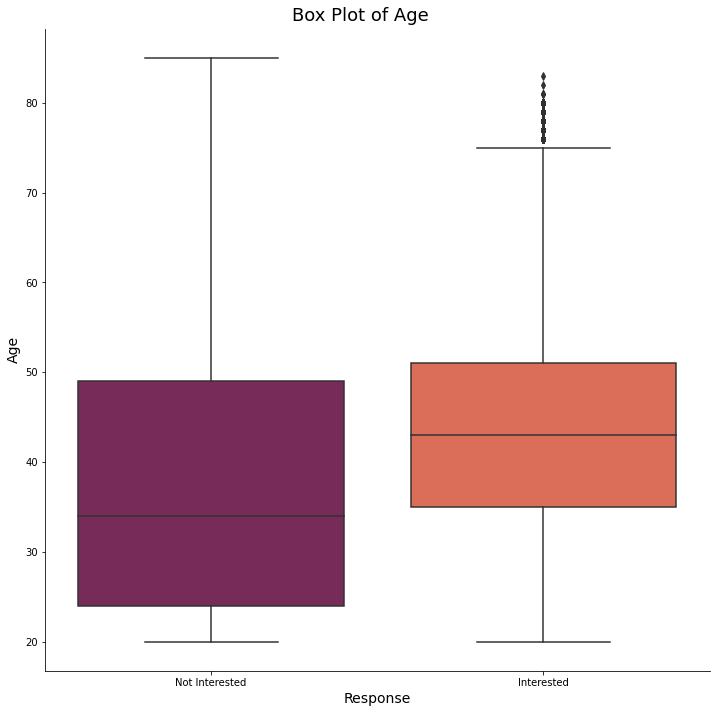

In [17]:
# set figure size
plt.figure(figsize=(10, 10))

# create box plots
sns.boxplot(x="Response", y="Age", palette="rocket", data=train)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# add title and axis labels
plt.suptitle("Box Plot of Age", size=18)
plt.ylabel("Age", size=14)
plt.xlabel("Response", size=14)

# update x tick labels
plt.xticks([0,1],['Not Interested','Interested'])

# remove top/right border
sns.despine()

plt.show()

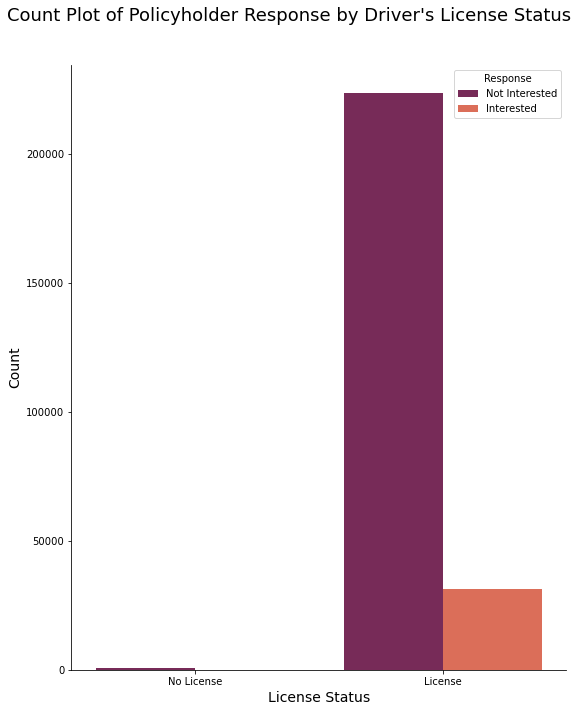

In [18]:
# set figure size
plt.figure(figsize=(8, 10))

# create countplot
sns.countplot(x=train.Driving_License, hue=train.Response, palette="rocket")

# update legend labels
plt.legend(labels=["Not Interested", "Interested"], title="Response")

# update x tick labels
plt.xticks([0,1],['No License','License'])

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# add title and axis labels
plt.suptitle("Count Plot of Policyholder Response by Driver's License Status", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("License Status", size=14)

# remove top/right border
sns.despine()

plt.show()

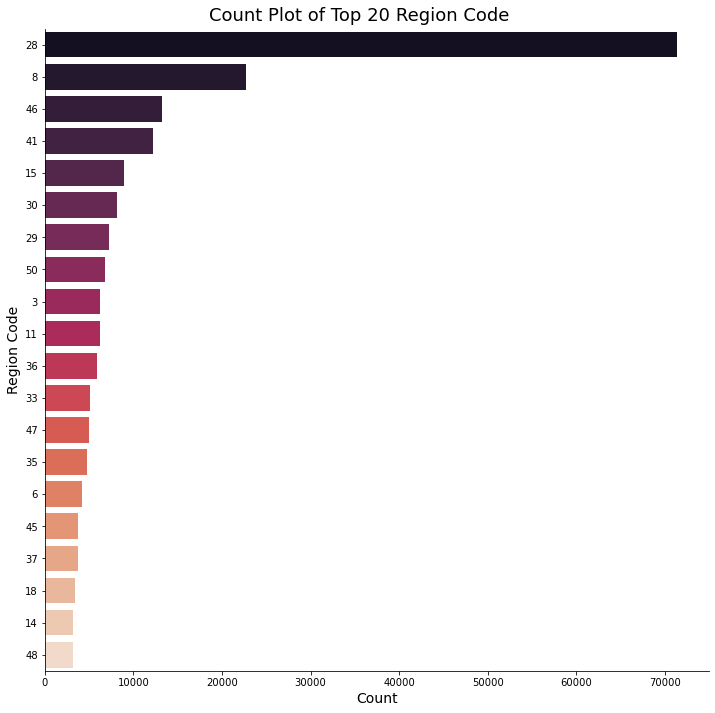

In [19]:
# set figure size
plt.figure(figsize=(10, 10))

# create countplot
sns.countplot(y=train.Region_Code, palette="rocket", order = train['Region_Code'].value_counts().iloc[:20].index)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# add title and axis labels
plt.suptitle("Count Plot of Top 20 Region Code", size=18)
plt.ylabel("Region Code", size=14)
plt.xlabel("Count", size=14)

# remove top/right border
sns.despine()

plt.show()

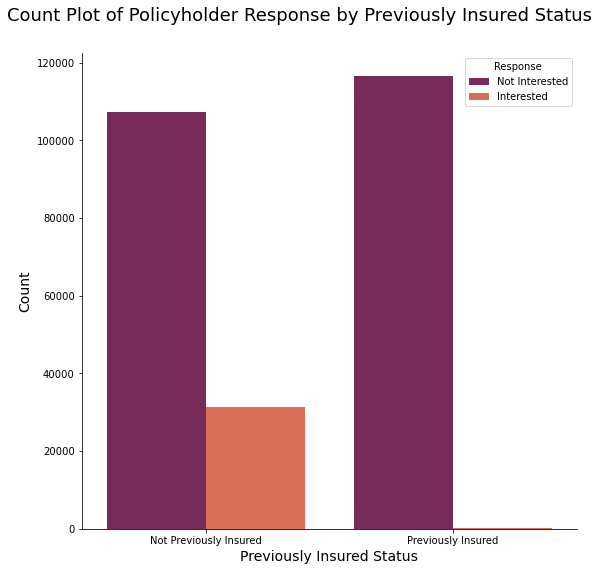

In [20]:
# set figure size
plt.figure(figsize=(8, 8))

# create countplot
sns.countplot(x=train.Previously_Insured, hue=train.Response, palette="rocket")

# update legend labels
plt.legend(labels=["Not Interested", "Interested"], title="Response")

# update x tick labels
plt.xticks([0,1],['Not Previously Insured','Previously Insured'])

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# add title and axis labels
plt.suptitle("Count Plot of Policyholder Response by Previously Insured Status", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Previously Insured Status", size=14)

# remove top/right border
sns.despine()

plt.show()

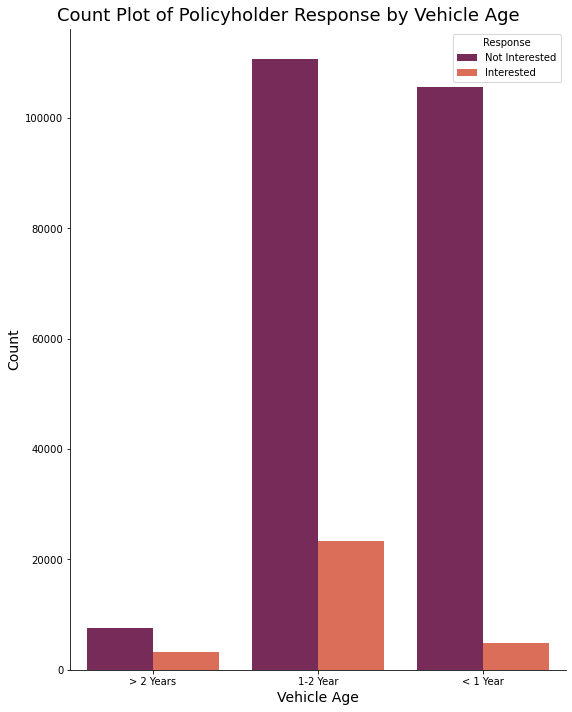

In [21]:
# set figure size
plt.figure(figsize=(8, 10))

# create countplot
sns.countplot(x=train.Vehicle_Age, hue=train.Response, palette="rocket")

# update legend labels
plt.legend(labels=["Not Interested", "Interested"], title="Response")

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# add title and axis labels
plt.suptitle("Count Plot of Policyholder Response by Vehicle Age", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Vehicle Age", size=14)

# remove top/right border
sns.despine()

plt.show()

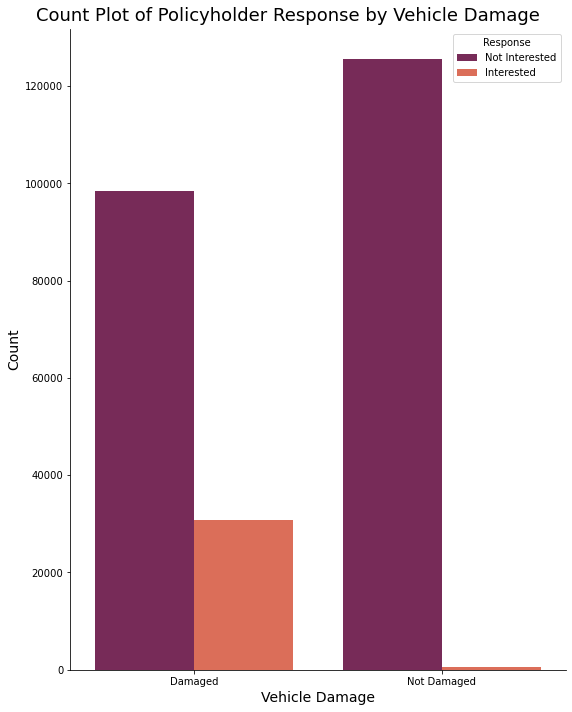

In [22]:
# set figure size
plt.figure(figsize=(8, 10))

# create countplot
sns.countplot(x=train.Vehicle_Damage, hue=train.Response, palette="rocket")

# update legend labels
plt.legend(labels=["Not Interested", "Interested"], title="Response")

# update x tick labels
plt.xticks([0,1],['Damaged','Not Damaged'])

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# add title and axis labels
plt.suptitle("Count Plot of Policyholder Response by Vehicle Damage", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Vehicle Damage", size=14)

# remove top/right border
sns.despine()

plt.show()

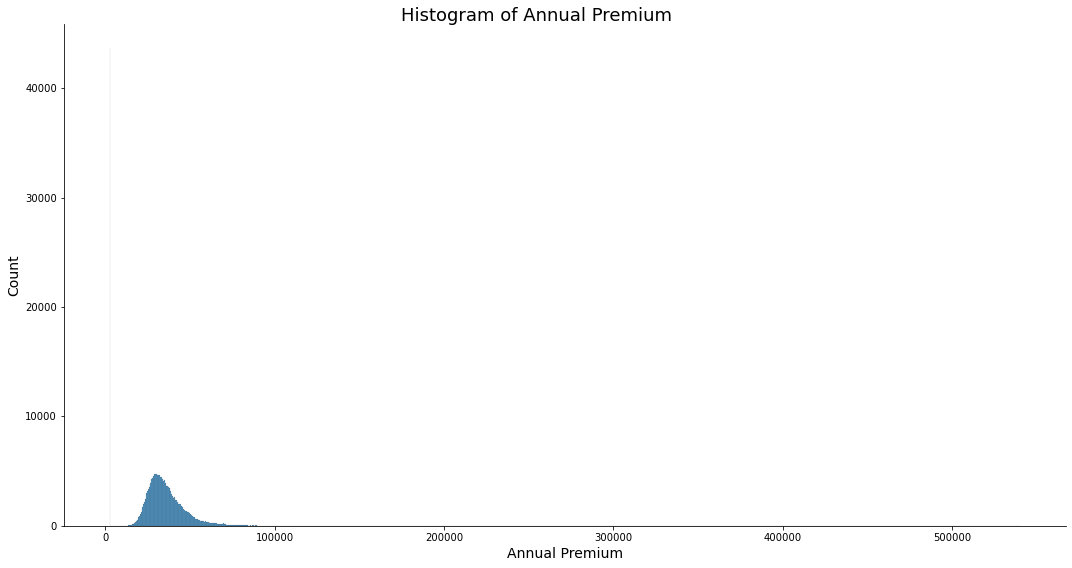

In [23]:
# set figure size
plt.figure(figsize=(15, 8))

# create countplot
sns.histplot(x=train.Annual_Premium, palette="rocket")

# add title and axis labels
plt.suptitle("Histogram of Annual Premium", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Annual Premium", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# remove top/right border
sns.despine()

plt.show()

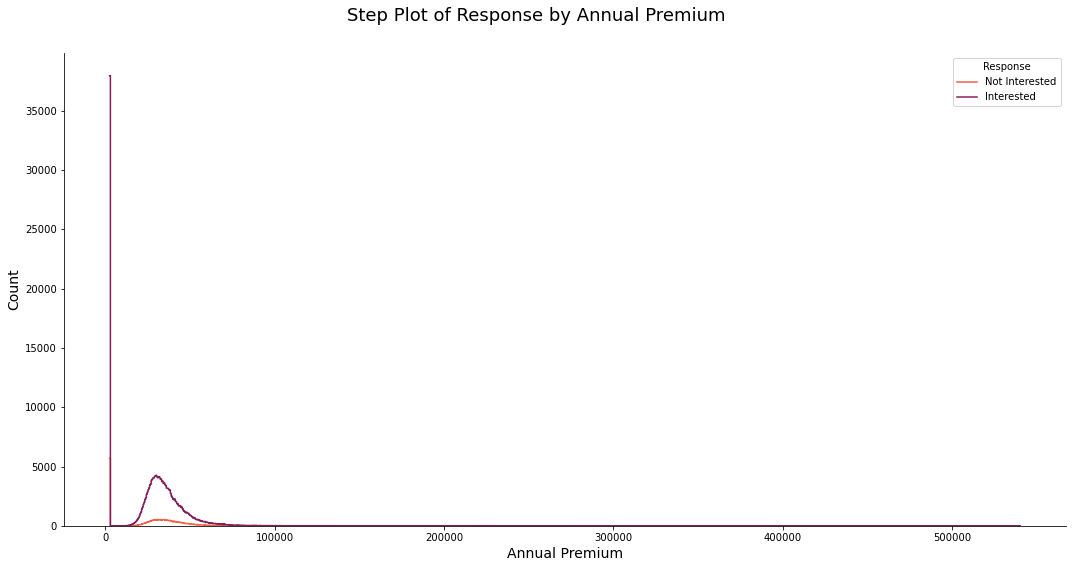

In [24]:
# set figure size
plt.figure(figsize=(15, 8))

# create hist plot
sns.histplot(data=train, x="Annual_Premium", hue='Response', element="step", fill=False, palette="rocket")

# add title and axis labels
plt.suptitle("Step Plot of Response by Annual Premium", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Annual Premium", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# update legend labels
plt.legend(labels=["Not Interested", "Interested"], title="Response")

# remove top/right border
sns.despine()

# display plot
plt.show()

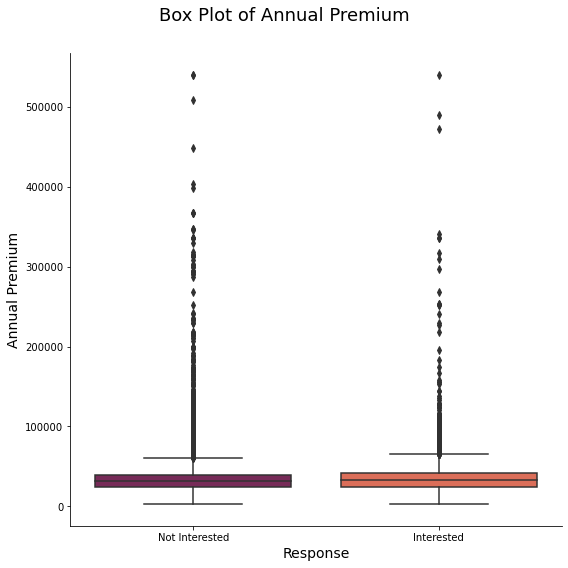

In [25]:
# set figure size
plt.figure(figsize=(8, 8))

# create box plots
sns.boxplot(x="Response", y="Annual_Premium", palette="rocket", data=train)

# add title and axis labels
plt.suptitle("Box Plot of Annual Premium", size=18)
plt.ylabel("Annual Premium", size=14)
plt.xlabel("Response", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# update x tick labels
plt.xticks([0,1],['Not Interested','Interested'])

# remove top/right border
sns.despine()

plt.show()

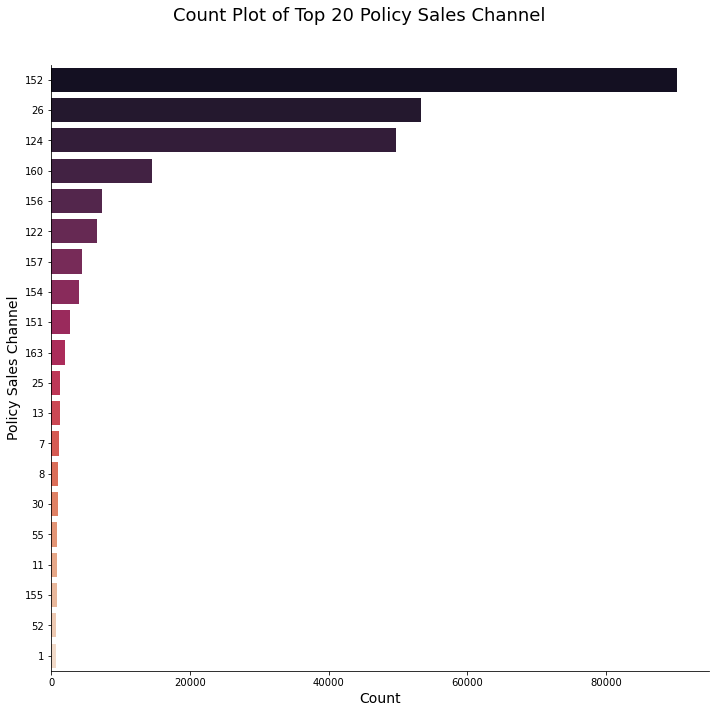

In [26]:
# set figure size
plt.figure(figsize=(10, 10))

# create countplot
sns.countplot(y=train.Policy_Sales_Channel, palette="rocket", order = train['Policy_Sales_Channel'].value_counts().iloc[:20].index)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# add title and axis labels
plt.suptitle("Count Plot of Top 20 Policy Sales Channel", size=18)
plt.ylabel("Policy Sales Channel", size=14)
plt.xlabel("Count", size=14)

# remove top/right border
sns.despine()

plt.show()

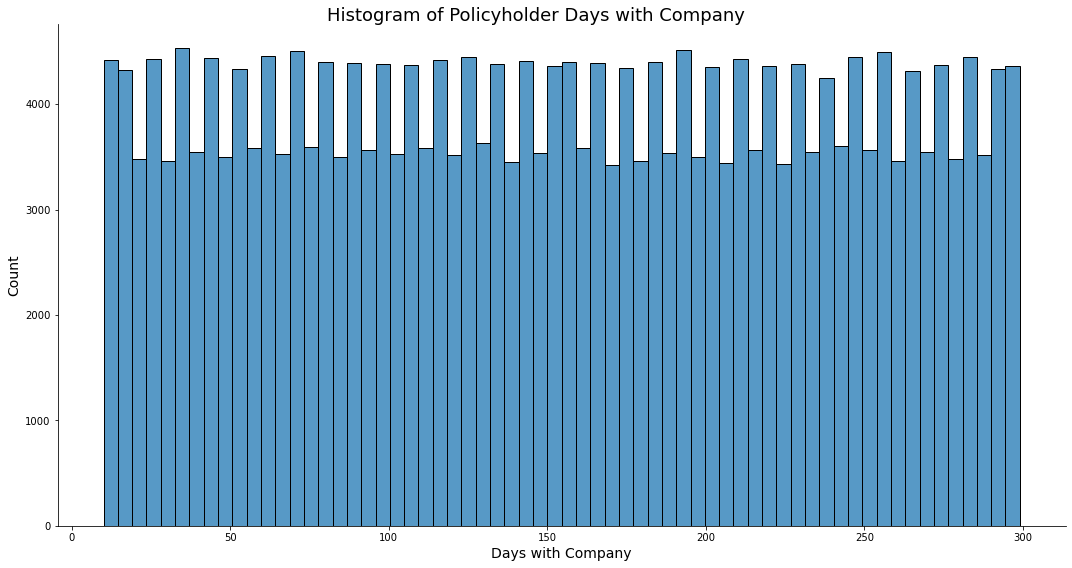

In [27]:
# set figure size
plt.figure(figsize=(15, 8))

# create countplot
sns.histplot(x=train.Vintage, palette="rocket")

# add title and axis labels
plt.suptitle("Histogram of Policyholder Days with Company", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Days with Company", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# remove top/right border
sns.despine()

plt.show()

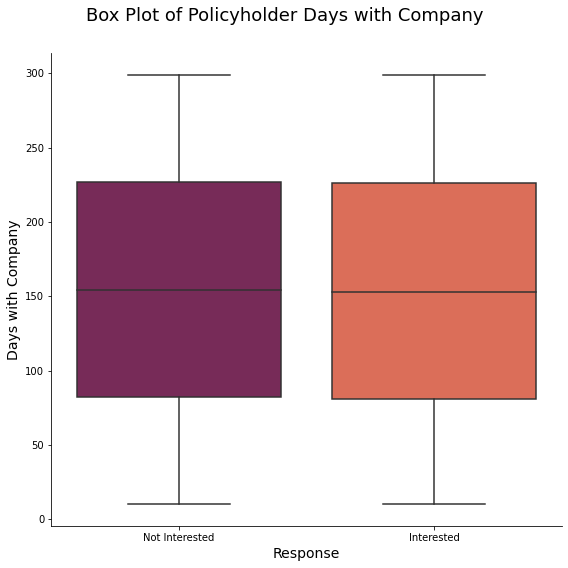

In [28]:
# set figure size
plt.figure(figsize=(8, 8))

# create box plots
sns.boxplot(x="Response", y="Vintage", palette="rocket", data=train)

# add title and axis labels
plt.suptitle("Box Plot of Policyholder Days with Company", size=18)
plt.ylabel("Days with Company", size=14)
plt.xlabel("Response", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# update x tick labels
plt.xticks([0,1],['Not Interested','Interested'])

# remove top/right border
sns.despine()

plt.show()

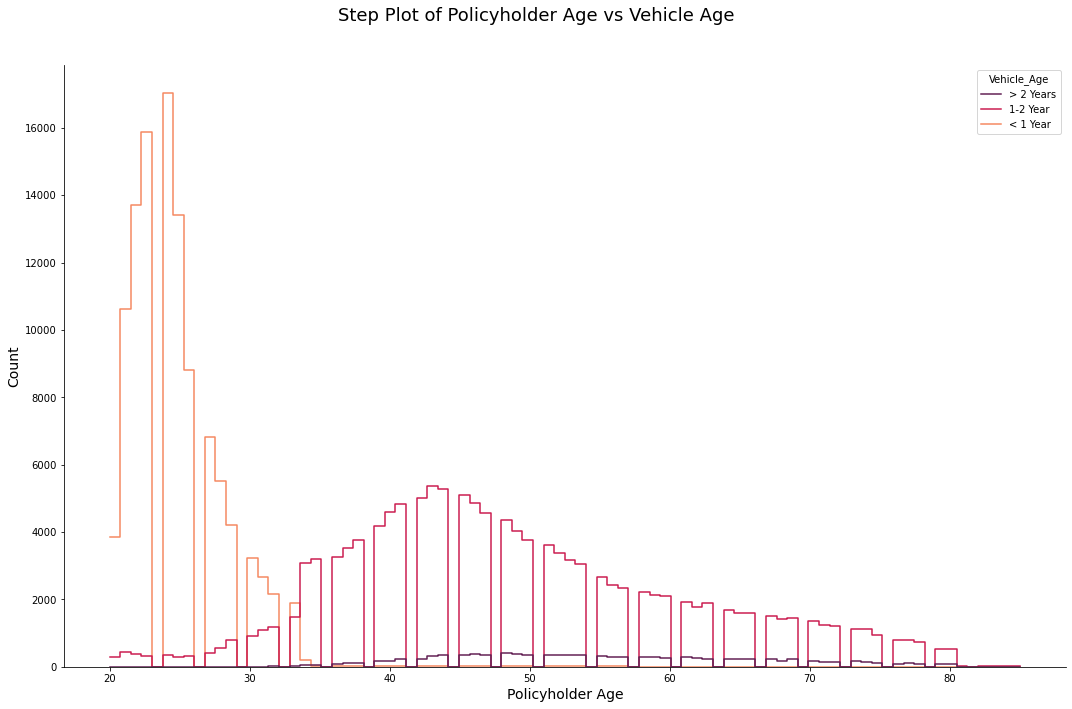

In [29]:
# set figure size
plt.figure(figsize=(15, 10))

# create hist plot
sns.histplot(data=train, x="Age", hue='Vehicle_Age', element="step", fill=False, palette="rocket")

# add title and axis labels
plt.suptitle("Step Plot of Policyholder Age vs Vehicle Age", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Policyholder Age", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# remove top/right border
sns.despine()

# display plot
plt.show()

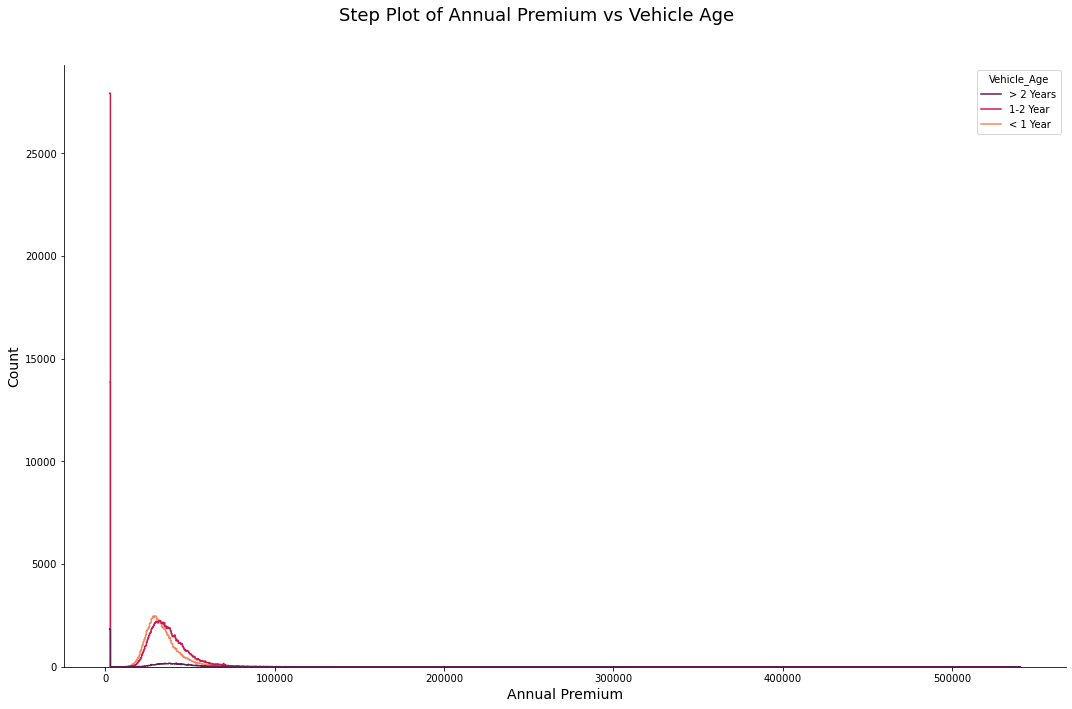

In [30]:
# set figure size
plt.figure(figsize=(15, 10))

# create hist plot
sns.histplot(data=train, x="Annual_Premium", hue='Vehicle_Age', element="step", fill=False, palette="rocket")

# add title and axis labels
plt.suptitle("Step Plot of Annual Premium vs Vehicle Age", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Annual Premium", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# remove top/right border
sns.despine()

# display plot
plt.show()

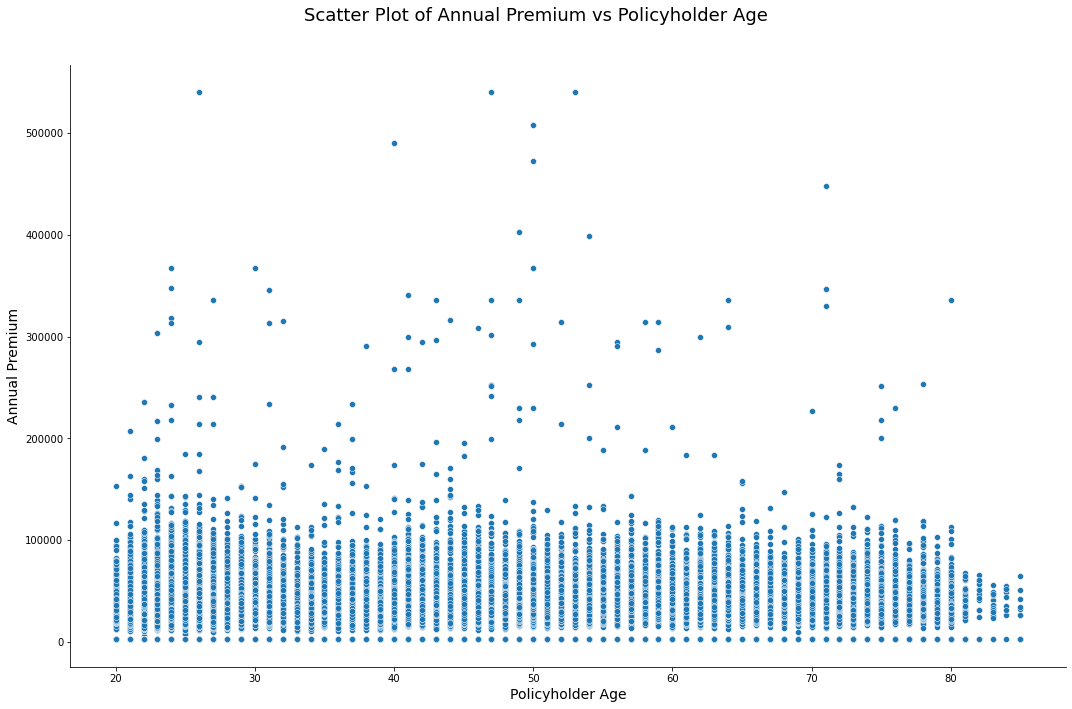

In [31]:
# set figure size
plt.figure(figsize=(15, 10))

# create scatter plot
sns.scatterplot(data=train, x="Age", y="Annual_Premium", palette="rocket")

# add title and axis labels
plt.suptitle("Scatter Plot of Annual Premium vs Policyholder Age", size=18)
plt.ylabel("Annual Premium", size=14)
plt.xlabel("Policyholder Age", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# remove top/right border
sns.despine()

# display plot
plt.show()

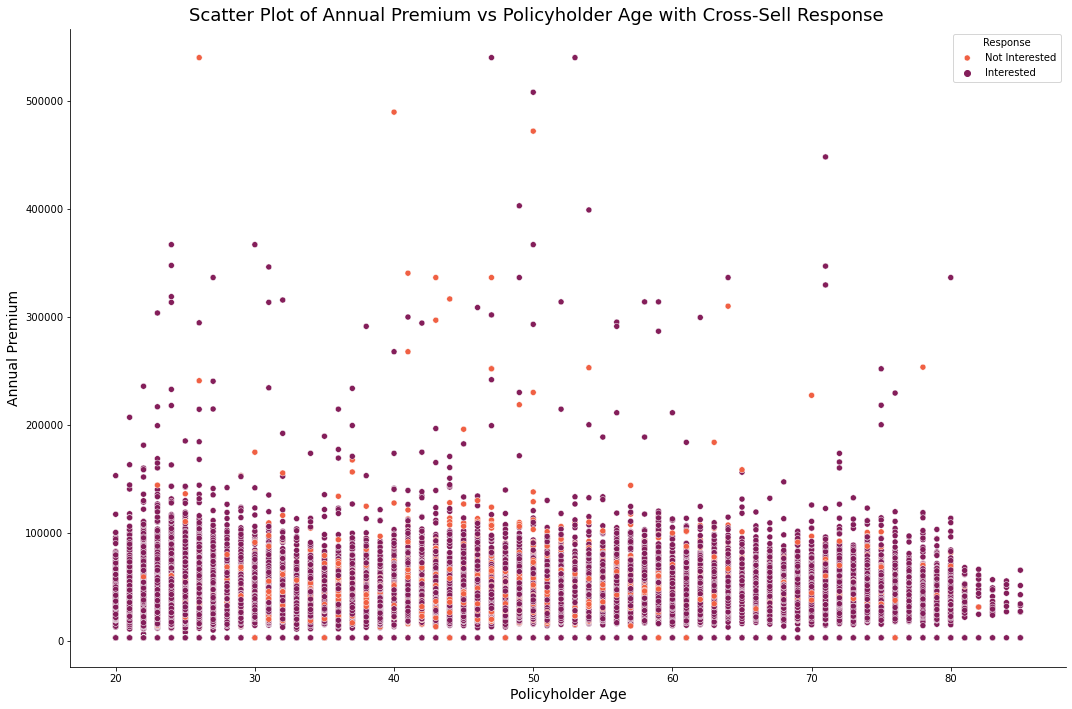

In [32]:
# set figure size
plt.figure(figsize=(15, 10))

# create scatter plot
sns.scatterplot(data=train, x="Age", y="Annual_Premium", hue="Response", palette="rocket")

# add title and axis labels
plt.suptitle("Scatter Plot of Annual Premium vs Policyholder Age with Cross-Sell Response", size=18)
plt.ylabel("Annual Premium", size=14)
plt.xlabel("Policyholder Age", size=14)

# update legend labels
plt.legend(labels=["Not Interested", "Interested"], title="Response")

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# remove top/right border
sns.despine()

# display plot
plt.show()

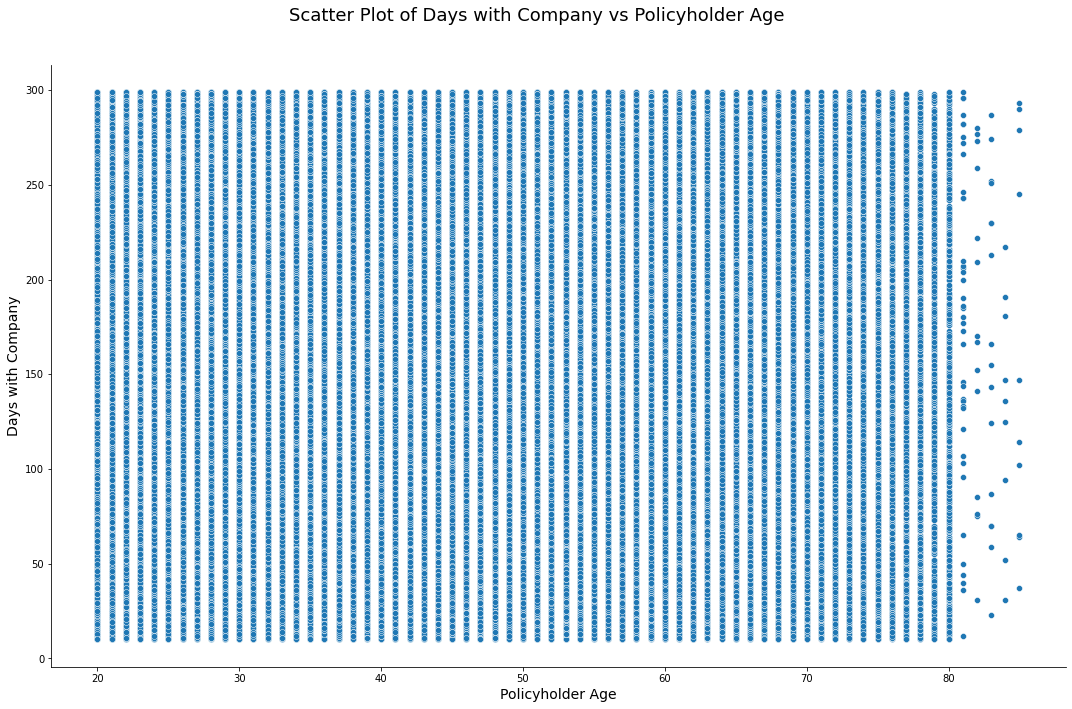

In [33]:
# set figure size
plt.figure(figsize=(15, 10))

# create scatter plot
sns.scatterplot(data=train, x="Age", y="Vintage", palette="rocket")

# add title and axis labels
plt.suptitle("Scatter Plot of Days with Company vs Policyholder Age", size=18)
plt.ylabel("Days with Company", size=14)
plt.xlabel("Policyholder Age", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# remove top/right border
sns.despine()

# display plot
plt.show()

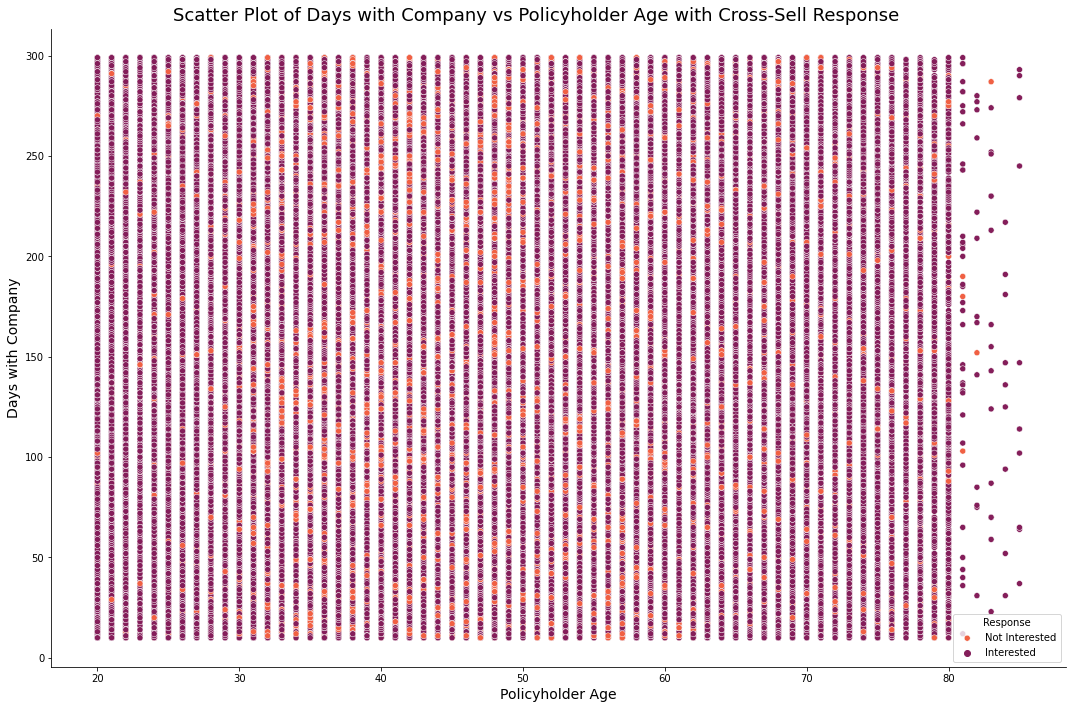

In [34]:
# set figure size
plt.figure(figsize=(15, 10))

# create scatter plot
sns.scatterplot(data=train, x="Age", y="Vintage", hue="Response", palette="rocket")

# add title and axis labels
plt.suptitle("Scatter Plot of Days with Company vs Policyholder Age with Cross-Sell Response", size=18)
plt.ylabel("Days with Company", size=14)
plt.xlabel("Policyholder Age", size=14)

# update legend labels
plt.legend(labels=["Not Interested", "Interested"], title="Response")

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# remove top/right border
sns.despine()

# display plot
plt.show()

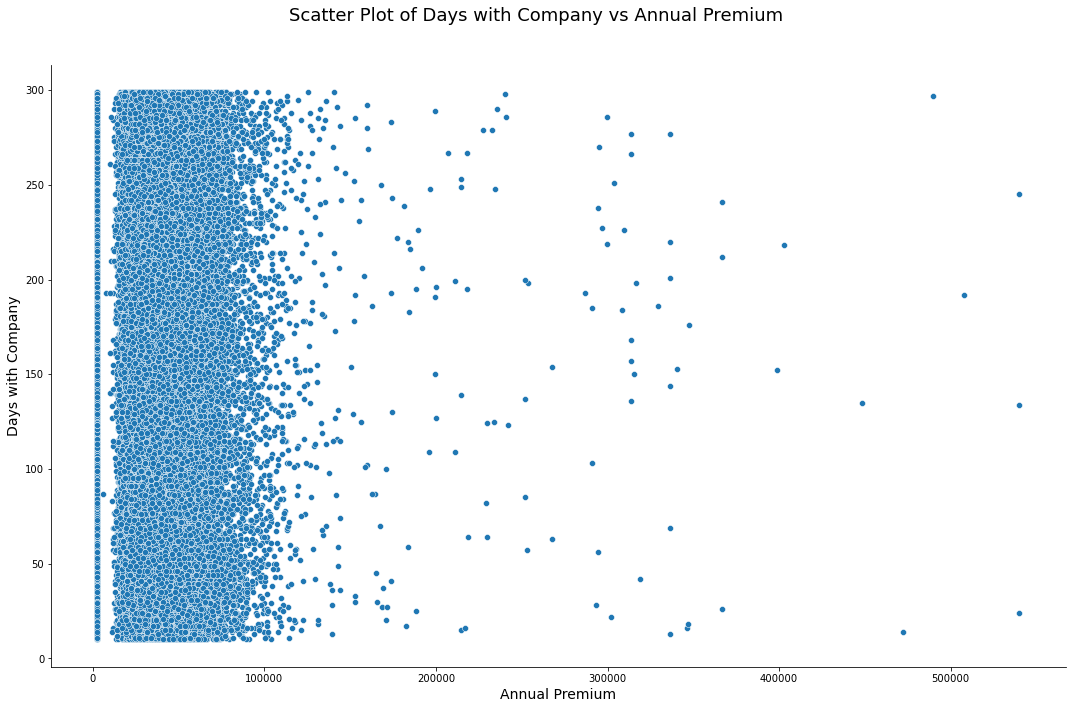

In [35]:
# premium x vintage

# set figure size
plt.figure(figsize=(15, 10))

# create scatter plot
sns.scatterplot(data=train, x="Annual_Premium", y="Vintage", palette="rocket")

# add title and axis labels
plt.suptitle("Scatter Plot of Days with Company vs Annual Premium", size=18)
plt.ylabel("Days with Company", size=14)
plt.xlabel("Annual Premium", size=14)

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# remove top/right border
sns.despine()

# display plot
plt.show()

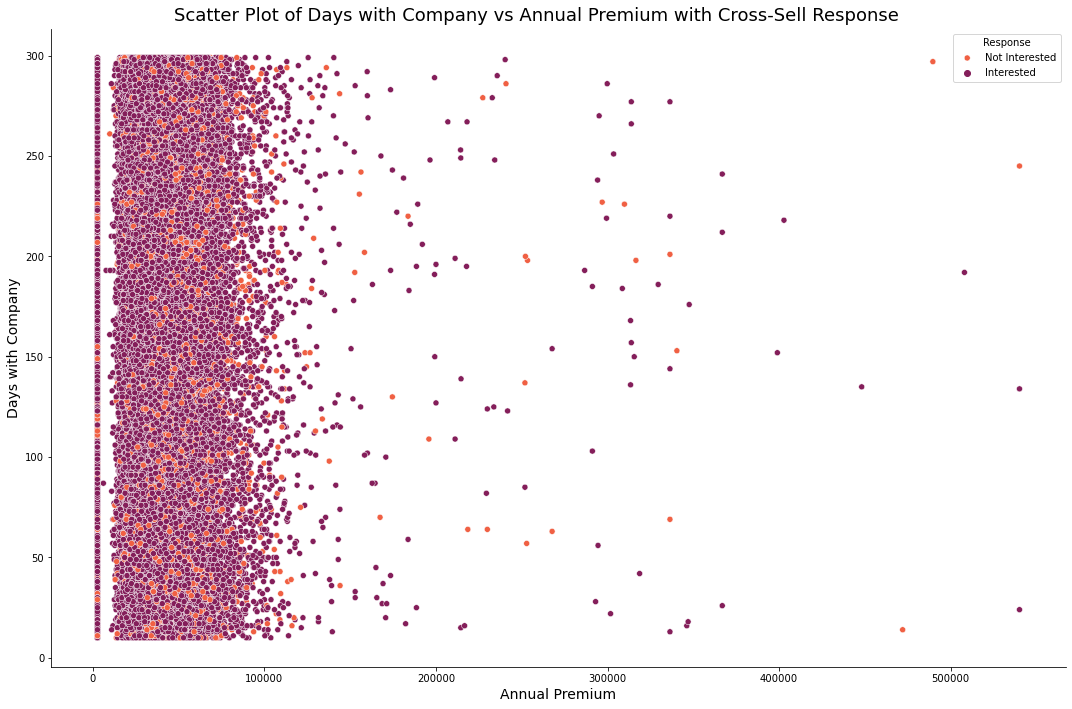

In [36]:
# set figure size
plt.figure(figsize=(15, 10))

# create scatter plot
sns.scatterplot(data=train, x="Annual_Premium", y="Vintage", hue="Response", palette="rocket")

# add title and axis labels
plt.suptitle("Scatter Plot of Days with Company vs Annual Premium with Cross-Sell Response", size=18)
plt.ylabel("Days with Company", size=14)
plt.xlabel("Annual Premium", size=14)

# update legend labels
plt.legend(labels=["Not Interested", "Interested"], title="Response")

# remove whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# remove top/right border
sns.despine()

# display plot
plt.show()

## Encoding

In [37]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1
1,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0
2,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1
3,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0
4,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0


In [38]:
# update binary values
train["Vehicle_Damage"].replace({"Yes": 1, "No": 0}, inplace=True)
test["Vehicle_Damage"].replace({"Yes": 1, "No": 0}, inplace=True)
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28,0,> 2 Years,1,40454.0,26,217,1
1,Male,76,1,3,0,1-2 Year,0,33536.0,26,183,0
2,Male,47,1,28,0,> 2 Years,1,38294.0,26,27,1
3,Male,21,1,11,1,< 1 Year,0,28619.0,152,203,0
4,Female,29,1,41,1,< 1 Year,0,27496.0,152,39,0


In [39]:
#Create object for one-hot encoding
encoder=ce.OneHotEncoder(cols=['Gender', 
                               'Region_Code',
                               'Vehicle_Age',
                               'Policy_Sales_Channel'],
                               return_df=True,
                               use_cat_names=True)

In [40]:
# encode categorical variables in test & train dataframes 
train_encoded = encoder.fit_transform(train)
test_encoded = encoder.fit_transform(test)

In [41]:
# view shape of new training data frame
train_encoded.shape

(255343, 215)

In [42]:
# view shape of new test data frame
test_encoded.shape

(125766, 210)

In [43]:
# remove redundant variable
train_encoded.drop('Gender_Female', axis=1, inplace=True)
test_encoded.drop('Gender_Female', axis=1, inplace=True)

# view new training data frame
train_encoded.head()

,Gender_Male,Age,Driving_License,Region_Code_28,Region_Code_3,Region_Code_11,Region_Code_41,Region_Code_33,Region_Code_6,Region_Code_35,...,Policy_Sales_Channel_70,Policy_Sales_Channel_2,Policy_Sales_Channel_34,Policy_Sales_Channel_33,Policy_Sales_Channel_74,Policy_Sales_Channel_102,Policy_Sales_Channel_149,Policy_Sales_Channel_43,Vintage,Response
0,1,44,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,217,1
1,1,76,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,183,0
2,1,47,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,27,1
3,1,21,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,203,0
4,0,29,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,39,0


## Feature Selection

#### Correlation Heatmap

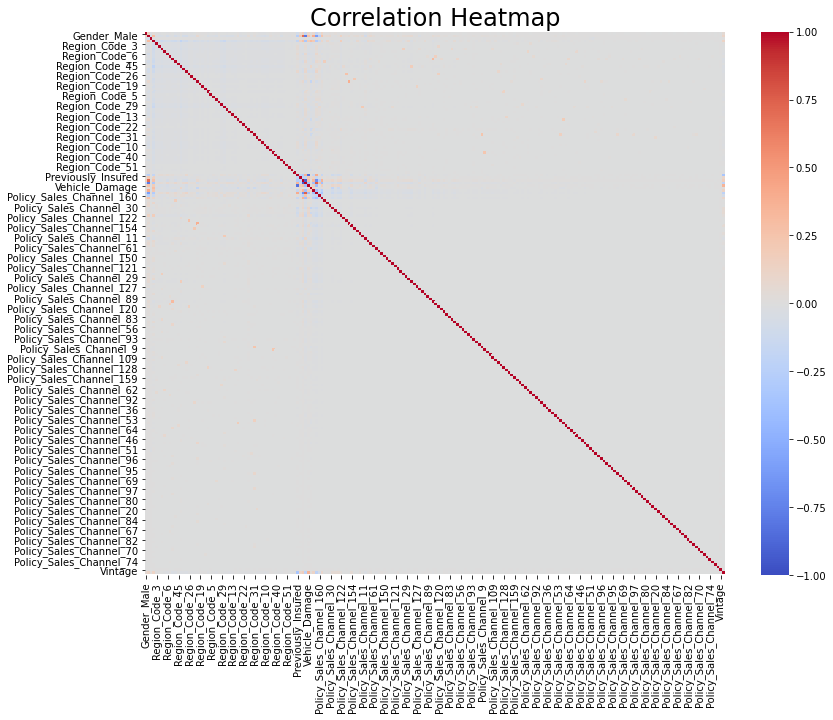

In [44]:
# check for highly correlated variables

# set figure size
plt.rcParams["figure.figsize"] = (13,10)

# create correlation heatmap
ax = sns.heatmap(train_encoded.corr(), #annot=True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center= 0, 
                 cmap= 'coolwarm')

# add title
plt.title("Correlation Heatmap", fontsize=24)

# adjust limits to fix cutoff issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# display plot
plt.show()

In [45]:
# split out dependent variable
y_train = train_encoded['Response']
y_test = test_encoded['Response']

In [46]:
# remove dependent variable from independent vars
X_train=train_encoded.drop('Response', 1)
X_test=test_encoded.drop('Response', 1)


In [47]:
print("X_train:")
X_train

X_train:


,Gender_Male,Age,Driving_License,Region_Code_28,Region_Code_3,Region_Code_11,Region_Code_41,Region_Code_33,Region_Code_6,Region_Code_35,...,Policy_Sales_Channel_99,Policy_Sales_Channel_70,Policy_Sales_Channel_2,Policy_Sales_Channel_34,Policy_Sales_Channel_33,Policy_Sales_Channel_74,Policy_Sales_Channel_102,Policy_Sales_Channel_149,Policy_Sales_Channel_43,Vintage
0,1,44,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,217
1,1,76,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,183
2,1,47,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27
3,1,21,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,203
4,0,29,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255338,1,61,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
255339,1,61,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,110
255340,1,23,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,248
255341,1,25,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21


In [48]:
print("y_train:")
y_train

y_train:


0         1
1         0
2         1
3         0
4         0
         ..
255338    1
255339    0
255340    0
255341    0
255342    0
Name: Response, Length: 255343, dtype: int64

In [49]:
# get relationship between features & target
mutual_info=mutual_info_classif(X_train,y_train, random_state=42)

# convert to series with index of column name
mutual_data=pd.Series(mutual_info,index=X_train.columns)

In [50]:
# print series in order
print(mutual_data.sort_values(ascending=False).to_string())

Previously_Insured          0.091685
Vehicle_Damage              0.088609
Driving_License             0.048650
Policy_Sales_Channel_152    0.034637
Vehicle_Age_< 1 Year        0.034592
Age                         0.030984
Vehicle_Age_1-2 Year        0.026107
Gender_Male                 0.013989
Region_Code_28              0.011118
Policy_Sales_Channel_26     0.007236
Policy_Sales_Channel_124    0.005872
Vehicle_Age_> 2 Years       0.005388
Policy_Sales_Channel_160    0.004617
Annual_Premium              0.003535
Region_Code_50              0.001876
Policy_Sales_Channel_156    0.001558
Region_Code_15              0.001385
Policy_Sales_Channel_58     0.001380
Policy_Sales_Channel_11     0.001352
Policy_Sales_Channel_103    0.001331
Region_Code_30              0.001282
Policy_Sales_Channel_154    0.001265
Policy_Sales_Channel_127    0.001233
Policy_Sales_Channel_89     0.001231
Policy_Sales_Channel_15     0.001205
Policy_Sales_Channel_115    0.001186
Policy_Sales_Channel_81     0.001169
R

In [51]:
# filter only values equal to 0
cols = mutual_data[mutual_data >= 0.001]

# convert to list
cols_list = list(cols.index.values.tolist())

# view list
cols_list

['Gender_Male',
 'Age',
 'Driving_License',
 'Region_Code_28',
 'Region_Code_50',
 'Region_Code_15',
 'Region_Code_30',
 'Region_Code_34',
 'Previously_Insured',
 'Vehicle_Age_> 2 Years',
 'Vehicle_Age_1-2 Year',
 'Vehicle_Age_< 1 Year',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel_26',
 'Policy_Sales_Channel_152',
 'Policy_Sales_Channel_160',
 'Policy_Sales_Channel_124',
 'Policy_Sales_Channel_156',
 'Policy_Sales_Channel_157',
 'Policy_Sales_Channel_15',
 'Policy_Sales_Channel_154',
 'Policy_Sales_Channel_11',
 'Policy_Sales_Channel_12',
 'Policy_Sales_Channel_127',
 'Policy_Sales_Channel_89',
 'Policy_Sales_Channel_83',
 'Policy_Sales_Channel_147',
 'Policy_Sales_Channel_64',
 'Policy_Sales_Channel_81',
 'Policy_Sales_Channel_103',
 'Policy_Sales_Channel_58',
 'Policy_Sales_Channel_115']

In [52]:
# include only desired features
X_train_final=X_train[cols_list]
X_train_final.head()

,Gender_Male,Age,Driving_License,Region_Code_28,Region_Code_50,Region_Code_15,Region_Code_30,Region_Code_34,Previously_Insured,Vehicle_Age_> 2 Years,...,Policy_Sales_Channel_12,Policy_Sales_Channel_127,Policy_Sales_Channel_89,Policy_Sales_Channel_83,Policy_Sales_Channel_147,Policy_Sales_Channel_64,Policy_Sales_Channel_81,Policy_Sales_Channel_103,Policy_Sales_Channel_58,Policy_Sales_Channel_115
0,1,44,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,76,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,47,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,21,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,29,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# align columns to training dataset
X_test_final=X_test[cols_list]

X_test_final.head()

,Gender_Male,Age,Driving_License,Region_Code_28,Region_Code_50,Region_Code_15,Region_Code_30,Region_Code_34,Previously_Insured,Vehicle_Age_> 2 Years,...,Policy_Sales_Channel_12,Policy_Sales_Channel_127,Policy_Sales_Channel_89,Policy_Sales_Channel_83,Policy_Sales_Channel_147,Policy_Sales_Channel_64,Policy_Sales_Channel_81,Policy_Sales_Channel_103,Policy_Sales_Channel_58,Policy_Sales_Channel_115
255343,1,21,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
255344,1,71,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
255345,0,76,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
255346,0,21,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
255347,0,26,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# rename data frames for simplicity
X_train = X_train_final
X_test = X_test_final

## Model Training

#### Create Pipelines

In [55]:
# logistic regression
pipe_lr = Pipeline([('selector', SelectKBest()),
                    ("classifier",LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear'))])

# random forest
pipe_rf = Pipeline([('selector', SelectKBest()),
                    ("classifier",RandomForestClassifier(random_state=42))])

# SVM
pipe_svm = Pipeline([('selector', SelectKBest()),
                    ("classifier",svm.SVC(random_state=42))])

#### Define Possible Values for Hyperparameters

In [56]:
# logistic regression
params_lr = {"selector__k": [4, 6, 8],
          "classifier__C": [10**i for i in range (-3,3)],
          "classifier__penalty": ['l1', 'l2']}

# random forest
params_rf = {"selector__k": [4, 6, 8],
             "classifier__n_estimators": [5, 50, 100],
             "classifier__class_weight": ['balanced',None],
             "classifier__max_depth": [2, 6, 10],
             "classifier__max_features": ['sqrt','log2',None]}

#### Create grid search with 5-fold cross-validation

In [57]:
# logistic regression
grid_lr = GridSearchCV(pipe_lr, 
                       param_grid=params_lr, 
                       #n_jobs=-1, 
                       scoring='roc_auc')

# random forest
grid_rf = GridSearchCV(pipe_rf, 
                       param_grid=params_rf, 
                       #n_jobs=-1, 
                       scoring='roc_auc')

#### Fit Grid Search

In [58]:
# logistic regression
grid_lr.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'selector__k': [4, 6, 8]},
             scoring='roc_auc')

In [59]:
# random forest
grid_rf.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [2, 6, 10],
                         'classifier__max_features': ['sqrt', 'log2', None],
                         'classifier__n_estimators': [5, 50, 100],
                         'selector__k': [4, 6, 8]},
             scoring='roc_auc')

#### Observe parameters with top scoring metrics

In [60]:
# logistic regression
pd.DataFrame(grid_lr.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
8,"{'classifier__C': 0.01, 'classifier__penalty':...",0.837073
26,"{'classifier__C': 10, 'classifier__penalty': '...",0.837055
29,"{'classifier__C': 10, 'classifier__penalty': '...",0.837055
35,"{'classifier__C': 100, 'classifier__penalty': ...",0.837055
32,"{'classifier__C': 100, 'classifier__penalty': ...",0.837054
20,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.837053
14,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.837053
23,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.837052
17,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.837043
11,"{'classifier__C': 0.01, 'classifier__penalty':...",0.837033


In [61]:
# random forest
pd.DataFrame(grid_rf.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
68,"{'classifier__class_weight': 'balanced', 'clas...",0.845933
149,"{'classifier__class_weight': None, 'classifier...",0.845894
59,"{'classifier__class_weight': 'balanced', 'clas...",0.845869
140,"{'classifier__class_weight': None, 'classifier...",0.845854
143,"{'classifier__class_weight': None, 'classifier...",0.845788
152,"{'classifier__class_weight': None, 'classifier...",0.845771
77,"{'classifier__class_weight': 'balanced', 'clas...",0.845756
71,"{'classifier__class_weight': 'balanced', 'clas...",0.845755
158,"{'classifier__class_weight': None, 'classifier...",0.845716
80,"{'classifier__class_weight': 'balanced', 'clas...",0.845653


#### Compare Best Scores & Best Hyperparameter Values

In [62]:
# logistic regression
grid_lr.best_score_, grid_lr.best_params_

(0.8370725531078962,
 {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'selector__k': 8})

In [63]:
# random forest
grid_rf.best_score_, grid_rf.best_params_

(0.8459326780206128,
 {'classifier__class_weight': 'balanced',
  'classifier__max_depth': 10,
  'classifier__max_features': 'log2',
  'classifier__n_estimators': 50,
  'selector__k': 8})

## Evaluation

#### Create Best Model

In [66]:
# create best model with tuned hyperparameters
best_model = Pipeline([('selector', SelectKBest(k=8)),
                      ('classifier', RandomForestClassifier(random_state=42, 
                                                            class_weight='balanced', 
                                                            max_depth=10, 
                                                            max_features='log2',
                                                            n_estimators=50))])

#### Confusion Matrix

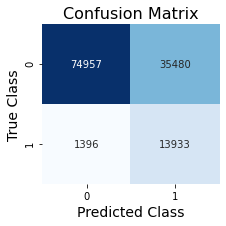

In [68]:
# use model to make predictions on the test features
y_pred = best_model.fit(X_train, y_train).predict(X_test)

# create confusion matrix
conf = confusion_matrix(y_test, y_pred)

# create data frame
matrix_df = pd.DataFrame(conf)

# create heatmap
plt.rcParams['figure.figsize'] = (3,3)
sns.heatmap(matrix_df, annot=True, fmt='g', cbar=None, cmap='Blues')
plt.title("Confusion Matrix", size=16), plt.tight_layout()
plt.ylabel("True Class", size=14), plt.xlabel("Predicted Class", size=14)
plt.show()

#### Evaluation Metrics Report

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.68      0.80    110437
           1       0.28      0.91      0.43     15329

    accuracy                           0.71    125766
   macro avg       0.63      0.79      0.62    125766
weighted avg       0.90      0.71      0.76    125766



#### ROC Curve

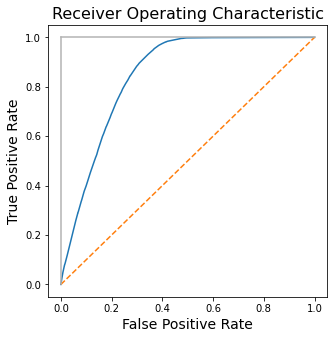

In [71]:
# train model
best_model.fit(X_train,y_train)

# get predicted probabilities
y_prob = best_model.predict_proba(X_test)[:,1]

# create true and false positive rates
false_pos_rate, true_pos_rate, threshold = roc_curve(y_test, y_prob)

# plot ROC curve
plt.rcParams['figure.figsize'] = (5,5)
plt.title("Receiver Operating Characteristic", size=16)
plt.plot(false_pos_rate, true_pos_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0], [1,0], c=".7"), plt.plot([1,1], c=".7")
plt.ylabel("True Positive Rate", size=14)
plt.xlabel("False Positive Rate", size=14)
plt.show()

In [72]:
#calculate area under curve
roc_auc_score(y_test, y_prob)

0.8488181030662432